# Assignment 6

In this assignment, you are expected to write your own collision avoidance system (CAS).
You are given a lot of freedom in order to accomplish this task. The implementation you see below is one way in which this can be done.

Your objective is to find a CAS policy $\pi(s) \rightarrow a$ which minimizes collisions and alerts. We want a safe system (few collisions) but we also do not want to alert when we do not need to (few alerts).

Collision avoidance systems will be judged according to a _cost function_ $J(\text{encounter}) \rightarrow \mathbb{R}$. 
We want to minimize the average penalty accumulated by the collision avoidance system. Formally:

$$\min_{\pi} \frac{1}{m} \sum_{i=1}^m \text{penalty}(\text{encounter}_i)$$

What this means is that we want the policy $\pi$ which on average produces encounters with minimum penalites.
We can estimate the performance of a policy by running a large number of encounters with it and then taking the mean of the accumulated penalty.

Penalties in this assignment are computed according to:

* a penalty of 10 for issuing an advisory - only issue advisories when you need to
* a penality equal to the magnitude of the advised climb rate each time a new advisory is issued - weak climb rates are easier on the passengers
* a penalty of 50 for a reversal - a change of sign in the advisory
* a penalty of 1e5 for an near mid-air collision (NMAC) - being within 100 ft vertically or 500 ft horizontally of another plane

### **What is Turned In:**
Edit the contents of this notebook and turn in our final Julia notebook file (.ipynb), and any associated code files you wrote to Coursework. Do not use any external code or Julia packages other than those used in the class materials.

### One: Set Up

In [1]:
using AA120Q, DataFrames, CSV
using Plots; gr()

Plots.GRBackend()

Here is a dataset of fully-human encounters, which you can then use to collect your own set of encounters to evaluate your Collision Avoidance System (CAS).

In [2]:
flights = CSV.read(joinpath(@__DIR__, "..", "data", "flights.csv"))
trajectories = pull_trajectories(flights, 500)

500-element Array{Array{EncounterState,1},1}:
 [EncounterState(AircraftState(0.0, 10313.0, 224.604, 0.0213703), AircraftState(-897.73, 10112.0, 243.037, 0.480057), 0.0), EncounterState(AircraftState(224.638, 10313.0, 224.673, -0.0922206), AircraftState(-654.645, 10112.5, 243.131, 0.458075), 1.0), EncounterState(AircraftState(449.327, 10312.9, 224.705, -0.185167), AircraftState(-411.497, 10113.0, 243.165, 0.448498), 2.0), EncounterState(AircraftState(673.982, 10312.6, 224.606, -0.237983), AircraftState(-168.325, 10113.4, 243.18, 0.41503), 3.0), EncounterState(AircraftState(898.599, 10312.4, 224.627, -0.24624), AircraftState(74.9007, 10113.8, 243.271, 0.389443), 4.0), EncounterState(AircraftState(1123.19, 10312.1, 224.548, -0.320292), AircraftState(318.158, 10114.1, 243.243, 0.269296), 5.0), EncounterState(AircraftState(1347.72, 10311.8, 224.51, -0.369824), AircraftState(561.424, 10114.3, 243.29, 0.0601332), 6.0), EncounterState(AircraftState(1572.32, 10311.4, 224.695, -0.351089), Aircra

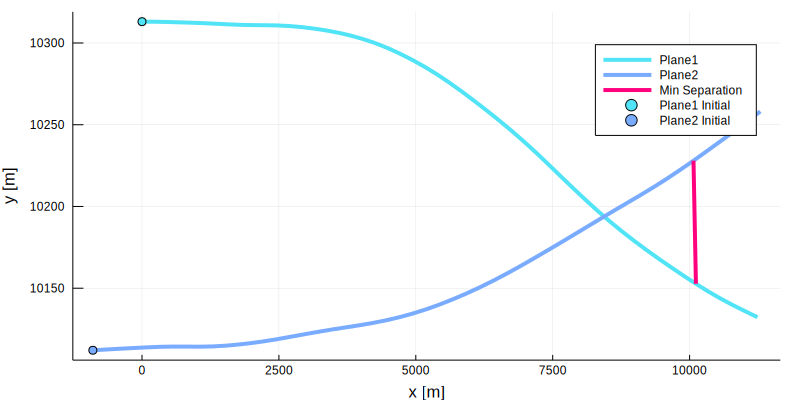

In [3]:
plot_trajectory(trajectories[1],1)   # Sample Plot

Here we're simulating trajectories using the [provided] traffic and collision avoidance system (TCAS). You will then design your own CAS (see below), and then compare the two results, to see if your model gets similar results as the standard model.

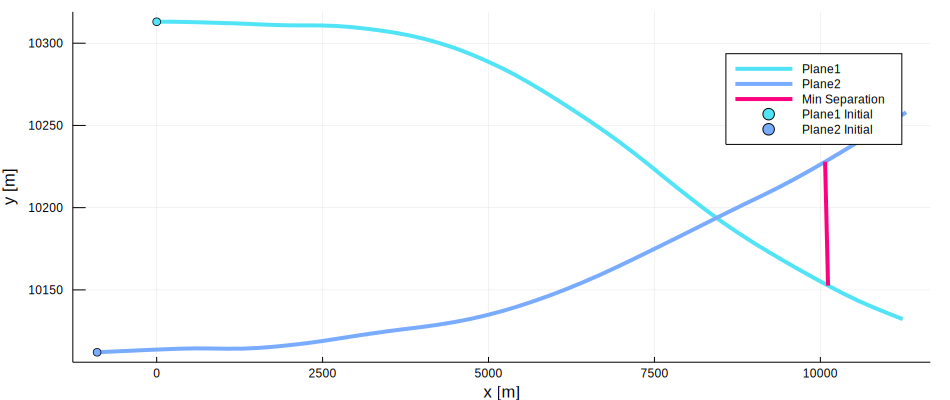

In [4]:
using Random
Random.seed!(0)
traj = rand(trajectories[1], TCAS())
plot_trajectory(traj)

## Milestone One: Improving the DCAS

In this milestone, we will take you through the steps of improving a collision avoidance system (CAS), by having you first implement a simple method of alerting a pilot of what to do in the event of a collision and then implementing a more sophisticated algorithm. The model will issue an Advisory (or none) at each timestep. Issuing ADVISORY_NONE or your previous advisory is equivalent to issuing no advisory.

## 1. Pull Away
First, we just want you to alert the pilot to pull away. 

This struct will contain the latest advisory warning you give. The range_threshold tells you the minimum distance that is allowed between the two aircraft. 

In [5]:
mutable struct DemoCAS <: FullyObservableCollisionAvoidanceSystem
    range_threshold::Float64
    last_advisory::Advisory
    DemoCAS(range_threshold::Float64, last_advisory::Advisory=ADVISORY_NONE) = new(range_threshold, last_advisory)
end

The reset function resets the warnings so that you start out with no advisories.

In [6]:
function AA120Q.reset!(dcas::DemoCAS)
    dcas.last_advisory = ADVISORY_NONE
    dcas
end

The update function issues an advisory and this is the part that we would like you to fill in. we have already provided some starter code and would just like you to issue a warning that pulls the aircraft upwards and away from the incoming second aircraft. 

In [7]:
using LinearAlgebra
function AA120Q.update!(dcas::DemoCAS, s1::AircraftState, s2::AircraftState, params::EncounterSimParams)

    # pull TCAS observations (get current state of both aircrafts)

    # determine distance of ego (first aircraft) from intruder (second aircraft)
    
    # STUDENT CODE START
    # STUDENT CODE END

    # test for activation
    if is_no_advisory(dcas.last_advisory) && range < dcas.range_threshold
        dcas.last_advisory = Advisory(CLIMB_RATE_MAX) # climb!
    end
        
    dcas.last_advisory
end

You can now simulate trajectories with your custom CAS...

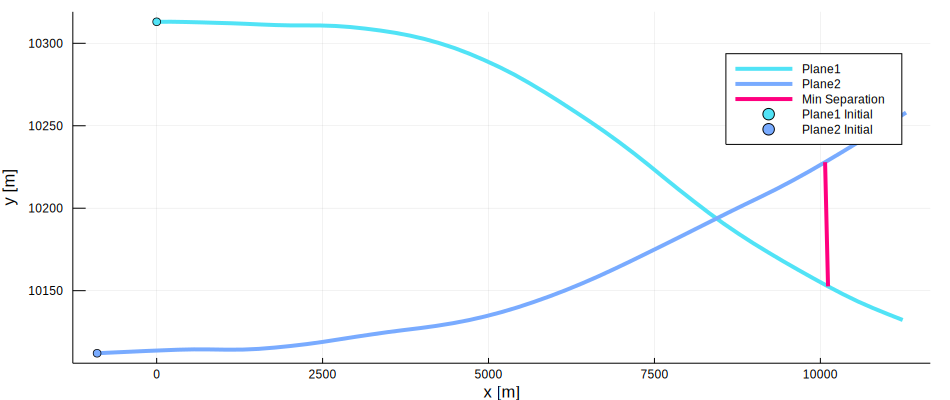

In [8]:
Random.seed!(0)
traj = rand(trajectories[1], DemoCAS(1000.0))
plot_trajectory(traj)

## 2. Predicted Minimum Separation

We can simply pull away from the first aircraft by flying up. However, there are more sophisticated ways of deciding what to tell the aircraft to do in the event of a warning. Now that you are familiar with the DCAS and just simply pulling away from the other aircraft, we want you to try to take into account the climb rate. 

To do so, take into account the climb rate of both aircraft, calculating whether or not you'll pass over them or below them. You then want to used this expected trajectory of both aircraft to see whether or not you should climb up or down.

Update this function:

In [9]:
function AA120Q.update!(dcas::DemoCAS, s1::AircraftState, s2::AircraftState, params::EncounterSimParams)
    
    # pull TCAS observations (get current state of both aircrafts)

    # determine distance of ego (first aircraft) from intruder (second aircraft)
    
    # determine whether the ego is above or below the intruder
    
    # STUDENT CODE START
    # STUDENT CODE END
        
    dcas.last_advisory
end

## Milestone Two: Make Your Own!

Now that you have implemented a simple CAS by just having the aircraft pull away and a more complex one that takes into account the distance from the second aircraft and distance above or below to determine which way to pull, we would like you to create a CAS that takes into account more variables than the previous two. You can use the first two as reference for the one you make. You can use factors such as velocity and acceleration.

For those of you who would like more of a challenge, you can also use apredictive model to estimate what the other plane will do. This will entail modeling the problem as a Markov Decision Process. You can use POMDPs.jl to solve it. You may want to go to office hours as well if you're interesting in implementing this solution.

In [10]:
function AA120Q.update!(dcas::DemoCAS, s1::AircraftState, s2::AircraftState, params::EncounterSimParams)
    # Your checks here
    
    # STUDENT CODE START
    # STUDENT CODE END

    dcas.last_advisory
end

## Milestone Three: Pull Evaluation Metrics

Use `evaluate` to report the number of advisories and near midair collisions (NMACs). Remember that a good safety system will minimize both the number of collisions and the number of alerts. We will measure performance based on the average cost per trajectory, `CASEval.normalized`. Try to minimize it!

In [11]:
# Run every encounter once
evaluate(DemoCAS(1000.0), trajectories)

CASEval(n_encounters: 500, n_advisories: 495, n_NMACs: 28, penalty: 2840837.50, normalized: 5681.68)

In [12]:
# randomly sample 50 encounters from `encounters`
evaluate(DemoCAS(1000.0), trajectories, 50)

CASEval(n_encounters: 50, n_advisories: 50, n_NMACs: 4, penalty: 404125.00, normalized: 8082.50)